In [1]:
import torch
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
from functools import partial  # can get rid of this if I define a class for collate
from torch.utils.data import Dataset, DataLoader
from data_loaders import ImageDataset, visual_collate_fn
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from data_config import *

jpg_pttrn = ".jpg"  # wikiart

In [2]:
visual_genome = ImageDataset(VG_PATH, pattern=jpg_pttrn)
flickr30k = ImageDataset(FLICKR_PATH, pattern=jpg_pttrn)
impressionism = ImageDataset(IMPRESSIONISM_PATH, pattern=jpg_pttrn)  # src https://github.com/cs-chan/ArtGAN/blob/master/WikiArt%20Dataset/README.md
# https://universe.roboflow.com/art-dataset/wiki-art pretrained model
# https://towardsdatascience.com/emotion-based-art-generation-using-c-gan-de9abed6fa2f
# https://universe.roboflow.com/art-dataset/wiki-art/dataset/2
vg_dataloader = DataLoader(impressionism, batch_size=4, shuffle=False,  #BATCH_SIZE
                           collate_fn=partial(visual_collate_fn, scaler_method=min))  # can only be min or max

In [3]:
vg_iter = iter(vg_dataloader)
batch1 = next(vg_iter)
#print(batch1)

In [ ]:
batch1[0].shape

In [23]:
#cv2.imshow(batch1[0])
#sample = "~/Pictures/profile_pic.jpg"  # does not like this one
#sample = "profile_pic.jpg"
BASE_PATH = "/media/andres/2D2DA2454B8413B5/software_proj"
visual_genome_path = "/visual_genome/VG_100K/"
VG_PATH = BASE_PATH + visual_genome_path
sample = VG_PATH + "107913.jpg"
sample = "original_demo_image_0.png"

In [24]:
image = cv2.imread(sample)  # must be in tree
height, width, channels = image.shape

In [25]:
image = cv2.imread(sample)
image_copy = image.copy() 
cv2.imshow('rar', image)
cv2.waitKey(5000)
cv2.destroyAllWindows()
#https://stackoverflow.com/questions/58100252/jupyter-kernel-crashes-when-trying-to-display-image-with-opencv

In [6]:
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

In [26]:
#wid, hgt = image.size
#img.show()
print(width, height)
nb_row = 3
nbr = 1
Wim = width//nb_row
Him = height//nb_row

for k in range(1, nb_row+1):
    for i in range(0, nb_row-k+1):
        for j in range(0, nb_row-k+1):

            title = 'image'+str(nbr)+'.jpg'
            #print(title)

            #

            # box = (0+(Wim)*ki, 0+(Him)*kj,Wim*(ki+1) ,Him*(kj+1) )
            box = (Wim*i, Him*j, Wim*(i+k), Him*(j+k))
            print(box)

            # img2 = img.crop(box)
            # img2 = img2.convert('RGB')
            # img2.save(f"{image_path}/"+title)
            # nbr += 1

800 588
(0, 0, 266, 196)
(0, 196, 266, 392)
(0, 392, 266, 588)
(266, 0, 532, 196)
(266, 196, 532, 392)
(266, 392, 532, 588)
(532, 0, 798, 196)
(532, 196, 798, 392)
(532, 392, 798, 588)
(0, 0, 532, 392)
(0, 196, 532, 588)
(266, 0, 798, 392)
(266, 196, 798, 588)
(0, 0, 798, 588)


In [27]:
def crop_dis(distance):    # https://learnopencv.com/cropping-an-image-using-opencv/
    options = [n for n in range(2, 10) if distance%n == 0]  # we don't want insane amount of crops
    print(distance, options)
    if len(options) == 1:
        result = options[0]    
    elif not options:
        result = distance
    else:
        if len(options) % 2 != 0:
            result = int(np.median(options))
        else:
            idx = len(options) // 2
            result = options[idx-1]  # upper end idx    
    return distance // result

print(crop_dis(width))
print(crop_dis(height))

800 [2, 4, 5, 8]
200
588 [2, 3, 4, 6, 7]
147


In [31]:
corr_width = crop_dis(width)
corr_height = crop_dis(height)
for y in range(0, height, corr_height):  # 800, 200
    
    for x in range(0, width, corr_width):  # 526, 263
        #print([i, i + corr_height, '|', j, j+corr_width])
        y1 = y + corr_height
        x1 = x + corr_width
        tiles = image_copy[y:y+corr_height, x:x+corr_width]
        print(tiles.shape)
        break
        #cv2.imwrite('tile'+str(y1)+'_'+str(x1)+'.jpg', tiles)
        cv2.rectangle(image, (x, y), (x1, y1), (0, 255, 0), 1)
        
# plt.imshow(image[:, :, ::-1])
# plt.axis('off')
#cv2.imwrite("patched.jpg",image)

800 [2, 4, 5, 8]
588 [2, 3, 4, 6, 7]
(147, 200, 3)
(147, 200, 3)
(147, 200, 3)
(147, 200, 3)


526 [2]
800 [2, 4, 5, 8]


True

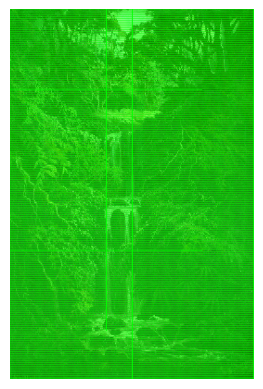

In [51]:
N = 104  # correlated with width
M = 76  # correlated with height. og height divided by this results in 3 cuts

#finding appropriate Ns and Ms
N = crop_dis(width)
M = crop_dis(height)
x1 = 0
y1 = 0
 
for y in range(0, height, M):
    for x in range(0, width, N):
        if (height - y) < M or (width - x) < N:
            break
             
        y1 = y + M
        x1 = x + N
 
        # check whether the patch width or height exceeds the image width or height
        if x1 >= width and y1 >= height:
            x1 = width - 1
            y1 = height - 1
            #Crop into patches of size MxN
            tiles = image_copy[y:y+M, x:x+N]
            #Save each patch into file directory
            #cv2.imwrite('saved_patches/'+'tile'+str(x)+'_'+str(y)+'.jpg', tiles)
            cv2.rectangle(image, (x, y), (x1, y1), (0, 255, 0), 1)
        elif y1 >= height: # when patch height exceeds the image height
            y1 = height - 1
            #Crop into patches of size MxN
            tiles = image_copy[y:y+M, x:x+N]
            #Save each patch into file directory
            #cv2.imwrite('saved_patches/'+'tile'+str(x)+'_'+str(y)+'.jpg', tiles)
            cv2.rectangle(image, (x, y), (x1, y1), (0, 255, 0), 1)
        elif x1 >= width: # when patch width exceeds the image width
            x1 = width - 1
            #Crop into patches of size MxN
            tiles = image_copy[y:y+M, x:x+N]
            #Save each patch into file directory
            #cv2.imwrite('saved_patches/'+'tile'+str(x)+'_'+str(y)+'.jpg', tiles)
            cv2.rectangle(image, (x, y), (x1, y1), (0, 255, 0), 1)
        else:
            #Crop into patches of size MxN
            tiles = image_copy[y:y+M, x:x+N]
            #Save each patch into file directory
            #cv2.imwrite('saved_patches/'+'tile'+str(x)+'_'+str(y)+'.jpg', tiles)
            cv2.imwrite('tile'+str(x)+'_'+str(y)+'.jpg', tiles)
            cv2.rectangle(image, (x, y), (x1, y1), (0, 255, 0), 1)
            
plt.imshow(image[:, :, ::-1])
plt.axis('off')
cv2.imwrite("patched.jpg",image)

In [15]:
width

526